## Desafio 2


Utilize a imagem da embalagem do iogurte, conforme a baixo, como alvo para obter suas características. Posteriormente, faça o mesmo buscando tais características em um vídeo promocional, para identificar o quanto da embalagem é exposto.

Aplique o algoritmo de extração de características ORB.
Para a correspondência de informações entre a embalagem e o vídeo, utilize o método de FLANN.

Após testes, estabeleça um limiar de pontos de correspondência e, por meio deste valor, informe se a embalagem é detectada ou não com um texto no próprio vídeo.

Logo Hellmanns

<img src="imagens/hellmanns-logo.jpg">

Captura de vídeo (apenas um frame)

<img src="imagens/hellmanns-capture.png">

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
print(cv2.__version__)

#Pop-up do Matplotlib
#%matplotlib qt

#Exibição na mesma tela do Jupyter
%matplotlib inline

#plt.rcParams["figure.figsize"]\
#(8,5)


from io import BytesIO
from IPython.display import clear_output, Image, display
import PIL


plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

3.4.2


/Users/michel.fernandes/anaconda/lib/python3.6/site-packages/joblib/_multiprocessing_helpers.py:28: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


Imagem de Treinamento, logotipo do pote.

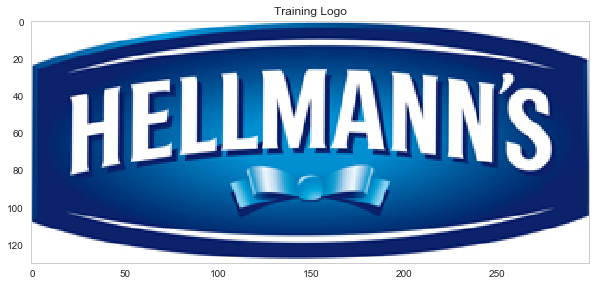

In [2]:
image_training = cv2.imread("imagens/hellmanns-logo.jpg")
image_training = cv2.cvtColor(image_training, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,8))
plt.imshow(image_training)
plt.title("Training Logo")

image_training_gray = cv2.cvtColor(image_training, cv2.COLOR_BGR2GRAY)

Imagem de busca, neste caso um trecho do vídeo

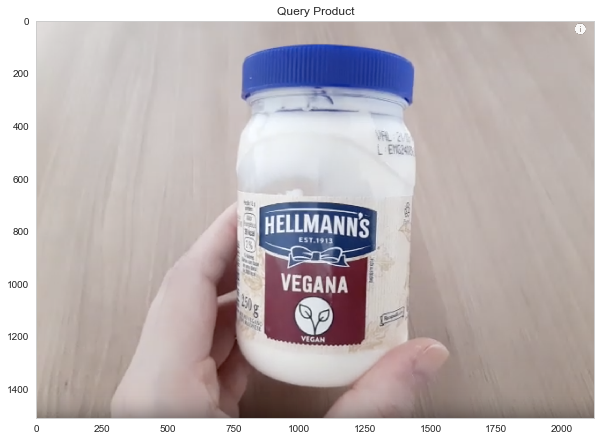

In [3]:
image_query = cv2.imread("imagens/hellmanns-capture.png")
image_query = cv2.cvtColor(image_query, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,8))
plt.imshow(image_query)
plt.title("Query Product")

image_query_gray = cv2.cvtColor(image_query, cv2.COLOR_BGR2GRAY)

Construindo o detector ORB

In [4]:
# Para identificar todos os pontos, exclua o número do construtor abaixo
orb_detector = cv2.ORB_create(1000)
kps_training = orb_detector.detect(image_training_gray, None)
kps_training, desc_training = orb_detector.compute(image_training_gray, kps_training)
print("Pontos detectados " + str(len(kps_training)))

Pontos detectados 404


Visualização das características encontradas

Text(0.5,1,'Logo Feature Vector')

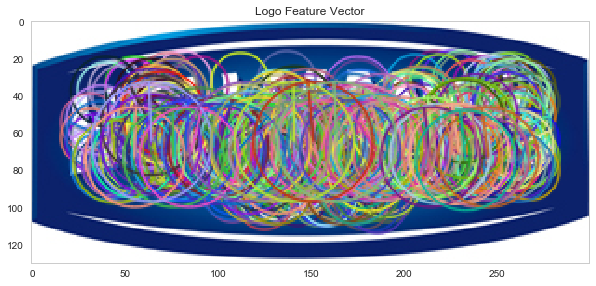

In [5]:
image_detected = image_training.copy()
image_detected = cv2.drawKeypoints(image_detected, kps_training, image_detected, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,8))
plt.imshow(image_detected)
plt.title("Logo Feature Vector")

Aplicando o detector para uma imagem de busca

In [6]:
kps = orb_detector.detect(image_query_gray, None)
kps_query, desc_query = orb_detector.compute(image_query_gray, kps)

Visualização de correspondência por FLANN

Text(0.5,1,'Hellmanns FLANN Descriptor')

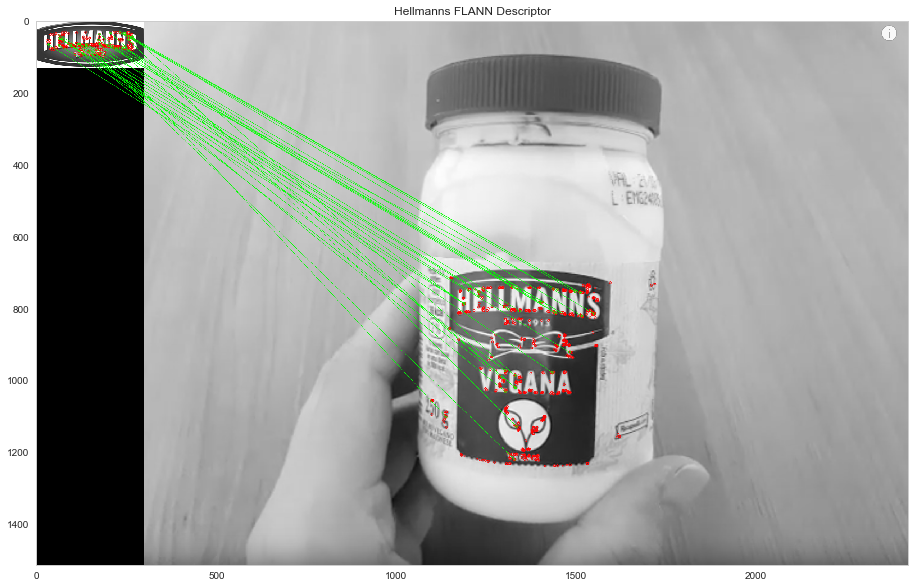

In [8]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH, table_number = 6, key_size = 12, multi_probe_level = 1) 
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc_training, desc_query, k=2)

matchesMask = [[0,0] for i in range(len(matches))]

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0), singlePointColor = (255,0,0), matchesMask = matchesMask, flags = 0)
image_detected = cv2.drawMatchesKnn(image_training_gray, kps_training, image_query_gray, kps_query, matches, None, **draw_params)

plt.figure(figsize=(20,10))
plt.imshow(image_detected)
plt.title("Hellmanns FLANN Descriptor")

Aplicando o mesmo conceito, porém frame a frame no vídeo

Text(0.5,1,'Exemplo')

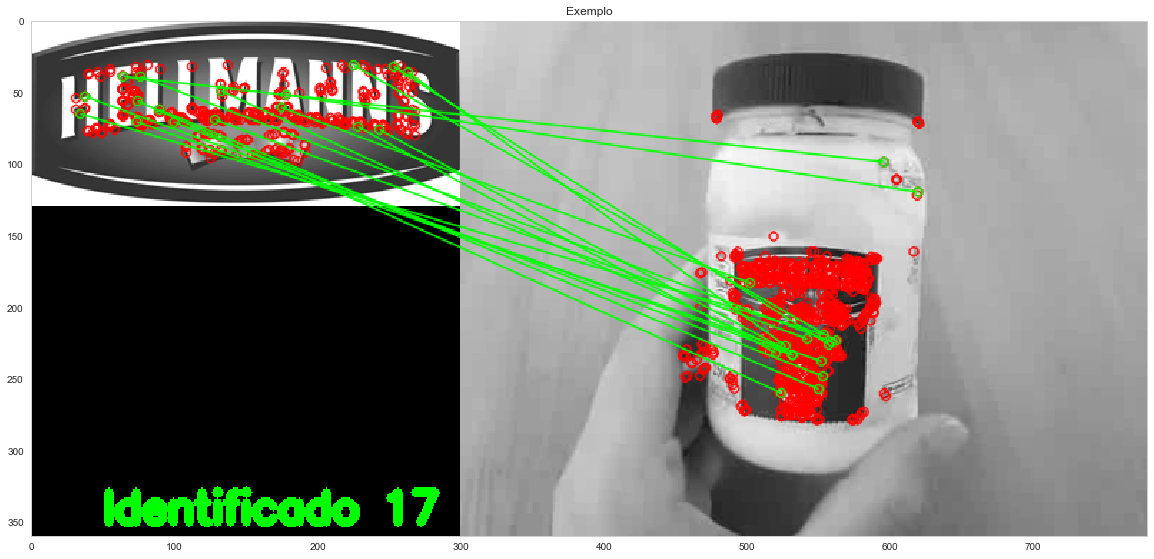

In [19]:
imagem_exemplo = cv2.imread("imagens/camera_output_1.png")

plt.figure(figsize=(20,10))
plt.imshow(imagem_exemplo)
plt.title("Exemplo")

In [20]:
from io import BytesIO
from IPython.display import clear_output, Image, display
import PIL

# Atenção, para interromper é clicar no menu do Jupyter, Kernel, Interrupt Kernel.

cam = cv2.VideoCapture("videos/hellmanns.avi")
try:
    while(True):
        is_capturing, frame = cam.read()
        if is_capturing:

            image_query_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)   
            
            kps = orb_detector.detect(image_query_gray, None)
            kps_query, desc_query = orb_detector.compute(image_query_gray, kps)

            FLANN_INDEX_LSH = 6
            index_params= dict(algorithm = FLANN_INDEX_LSH, table_number = 6, key_size = 12, multi_probe_level = 1) 
            search_params = dict(checks=50)

            flann = cv2.FlannBasedMatcher(index_params, search_params)
            matches = flann.knnMatch(desc_training, desc_query, k=2)

            matchesMask = [[0,0] for i in range(len(matches))]
            
            good_matches = []
            
            try:
                for i,(m,n) in enumerate(matches):
                    if m.distance < 0.8*n.distance:
                        matchesMask[i]=[1,0]
                        good_matches.append(m)
            except:
                pass

            draw_params = dict(matchColor = (0,255,0), singlePointColor = (255,0,0), matchesMask = matchesMask, flags = 0)
            image_detected = cv2.drawMatchesKnn(image_training_gray, kps_training, image_query_gray, kps_query, matches, None, **draw_params)
            
            cv2.putText(image_detected, "Identificado " + str(len(good_matches)), (50,350), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 6)

            img = PIL.Image.fromarray(image_detected, "RGB")
            buffer = BytesIO()
            img.save(buffer,format="JPEG")        
            display(Image(data=buffer.getvalue()))
            
            cv2.imwrite("imagens/camera_output_1.png", image_detected)

        clear_output(wait=True)
except KeyboardInterrupt:
    cam.release()
    print("Interrompido")

Interrompido


Para melhorar a performance, vamos segmentar os frames em um retângulo delimitador

In [10]:
# Na função não vamos desenhar as correspondências de KNN, logo não é preciso construir a máscara nem utilizar o método
# de desenho destas correspondências.

# Utilize o try/catch pois as vezes os matches obtidos dos frames podem vir incompletos

def detectar_embalagem_orb(image, desc_training):
    
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm = FLANN_INDEX_LSH, table_number = 6, key_size = 12, multi_probe_level = 1) 
    search_params = dict(checks=100)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    image_target_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    kps = orb_detector.detect(image_target_gray, None)
    kps_target, desc_query = orb_detector.compute(image_target_gray, kps)
    
    good_matches = []
    
    try:
        matches = flann.knnMatch(desc_training, desc_query, k=2)
        for (m,n) in matches:
            if m.distance < 0.8*n.distance:
                good_matches.append(m)
    except:
        pass
    
    return len(good_matches)

Text(0.5,1,'Exemplo')

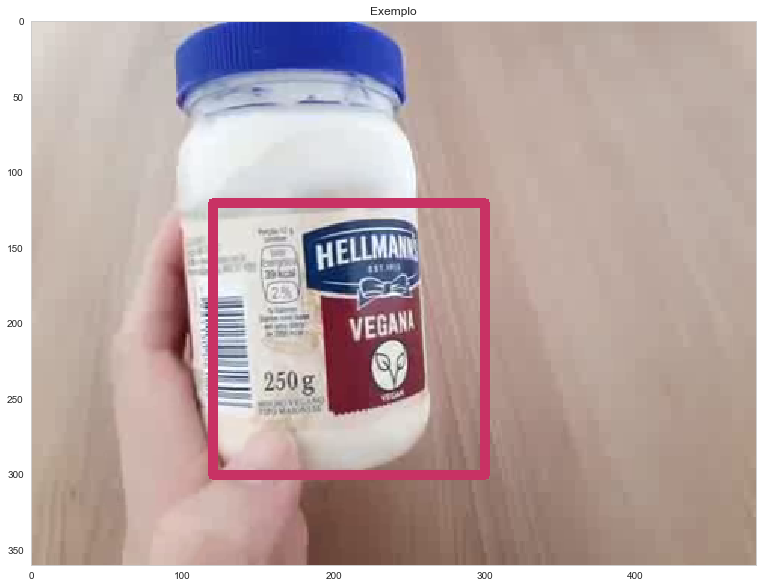

In [27]:
imagem_exemplo_2 = cv2.imread("imagens/camera_output_2.png")

plt.figure(figsize=(20,10))
plt.imshow(imagem_exemplo_2)
plt.title("Exemplo")

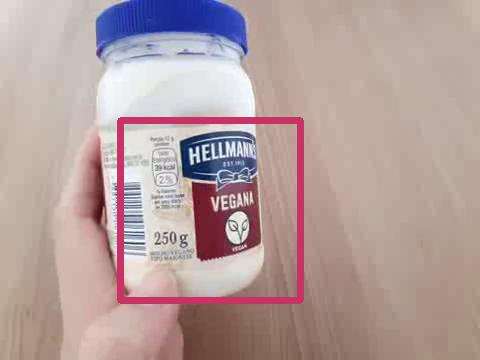

Interrompido


In [26]:
# Atenção, para interromper é clicar no menu do Jupyter, Kernel, Interrupt Kernel.

upper_left = (120, 120)
bottom_right = (300, 300)

cam = cv2.VideoCapture("videos/hellmanns.avi")

try:
    while(True):
        is_capturing, frame = cam.read()
        if is_capturing:
            #Rectangle marker
            r = cv2.rectangle(frame, upper_left, bottom_right, (100, 50, 200), 5)
            rect_img = frame[upper_left[1] : bottom_right[1], upper_left[0] : bottom_right[0]]
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            matches = detectar_embalagem_orb(rect_img, desc_training)
            
            if matches>20:
                cv2.putText(frame, "Identificado Rotulo", (50,350), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 6)
                
            img = PIL.Image.fromarray(frame, "RGB")
            buffer = BytesIO()
            img.save(buffer,format="JPEG")        
            display(Image(data=buffer.getvalue()))
            
            cv2.imwrite("imagens/camera_output_2.png", frame)

        clear_output(wait=True)
except KeyboardInterrupt:
    cam.release()
    print("Interrompido")

## Método por câmera

Text(0.5,1,'Exemplo')

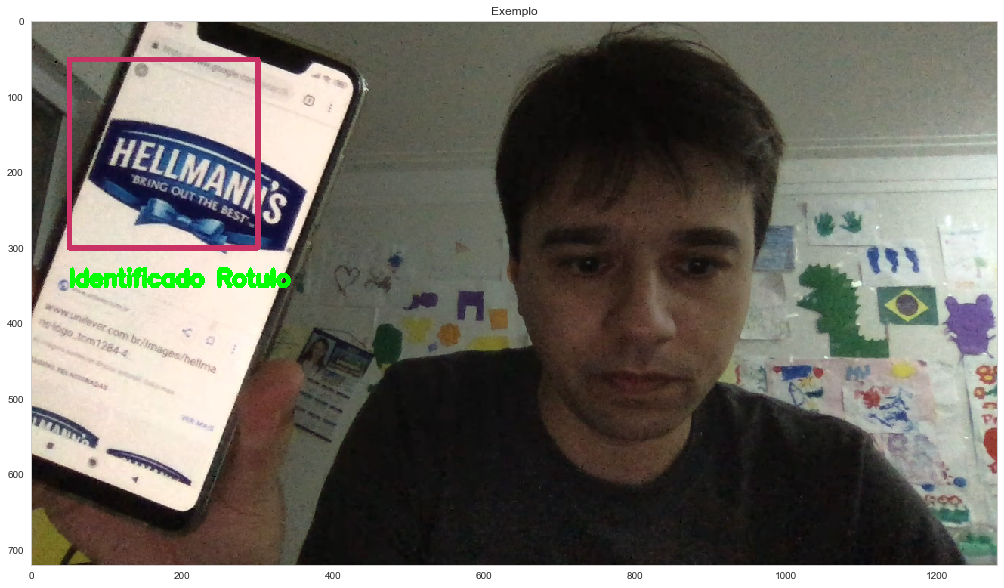

In [28]:
imagem_exemplo_2 = cv2.imread("imagens/camera_output_3.png")

plt.figure(figsize=(20,10))
plt.imshow(imagem_exemplo_2)
plt.title("Exemplo")

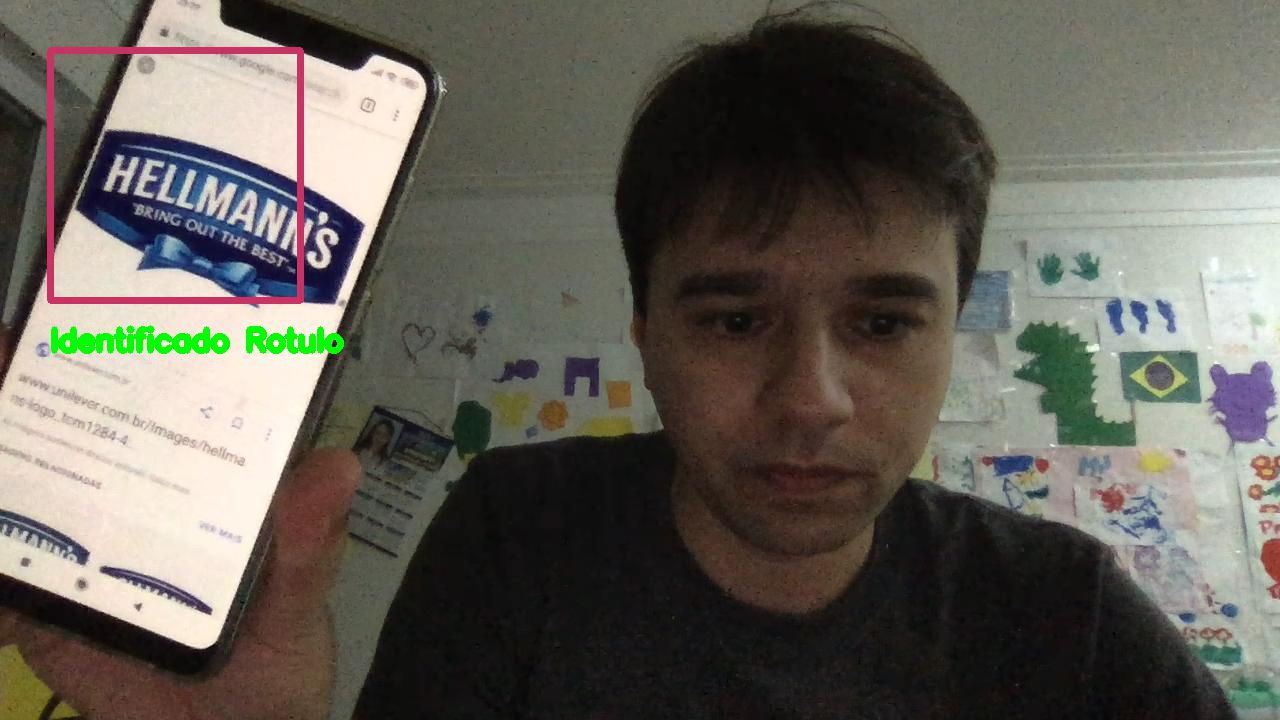

Interrompido


In [25]:
upper_left = (50, 50)
bottom_right = (300, 300)

cam.release()
cam = cv2.VideoCapture(0)

try:
    while(True):
        is_capturing, frame = cam.read()
        if is_capturing:
            #Rectangle marker
            r = cv2.rectangle(frame, upper_left, bottom_right, (100, 50, 200), 5)
            rect_img = frame[upper_left[1] : bottom_right[1], upper_left[0] : bottom_right[0]]
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            matches = detectar_embalagem_orb(rect_img, desc_training)
            
            if matches>20:
                cv2.putText(frame, "Identificado Rotulo", (50,350), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 6)
                
            img = PIL.Image.fromarray(frame, "RGB")
            buffer = BytesIO()
            img.save(buffer,format="JPEG")        
            display(Image(data=buffer.getvalue()))
            
            cv2.imwrite("imagens/camera_output_3.png", frame)

        clear_output(wait=True)
except KeyboardInterrupt:
    cam.release()
    print("Interrompido")